Regression with features obtained by forward feature selection.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from collections import OrderedDict
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = 'https://raw.githubusercontent.com/sarahyurick/datasets/master/alc_merged.csv'
data = pd.read_csv(url)
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [3]:
drop_col = ['school', 'age', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
            'nursery']
data = data.drop(columns=drop_col)

# handle non-numeric features
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
# print(non_numeric_columns)
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

data = struct_data
data.columns

Index(['sex', 'address', 'studytime', 'failures', 'schoolsup', 'famsup',
       'paid', 'activities', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')

Forward Selection: "addressU"     "studytime"    "failures"     "schoolsupyes" "famrel"       "freetime"     "Dalc"         "health"      
 "absences"     "G1"           "G2"           "G3"

In [4]:
data['constant'] = 1

for col in ['studytime', 'failures', 'famrel', 'freetime', 'health', 'absences', 'G1', 'G2']:
    data['{}^2'.format(col)] = data[col] * data[col]

In [5]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
    return weights

In [6]:
binary_dalc = []
for amount in data['Dalc']:
  if amount < 3:
    binary_dalc.append(0)
  else:
    binary_dalc.append(1)

data['binary_Dalc'] = binary_dalc
data.head()

,sex,address,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,constant,studytime^2,failures^2,famrel^2,freetime^2,health^2,absences^2,G1^2,G2^2,binary_Dalc
0,0,1,2,0,1,0,0,0,1,0,0,4,3,4,1,1,3,6,5,6,6,1,4,0,16,9,9,36,25,36,0
1,0,1,2,0,0,1,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,4,0,25,9,9,16,25,25,0
2,0,1,2,3,1,0,1,0,1,1,0,4,3,2,2,3,3,10,7,8,10,1,4,9,16,9,9,100,49,64,0
3,0,1,3,0,0,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,1,9,0,9,4,25,4,225,196,0
4,0,1,2,0,0,1,1,0,1,0,0,4,3,2,1,2,5,4,6,10,10,1,4,0,16,9,25,16,36,100,0


In [7]:
# 'studytime', 'failures', 'famrel', 'freetime', 'health', 'absences', 'G1', 'G2'
X_ip = data[[
             'constant', 'address', 
             'studytime', 'studytime^2',
             'failures', 'failures^2',
             'famrel', 'famrel^2', 
             'freetime', 'freetime^2', 
             'health', 'health^2', 
             'absences', 'absences^2', 
             'G1', 'G1^2', 
             'G2', 'G2^2'
]]

denoms = logit_ip_f(data.binary_Dalc, X_ip)
weights = 1 / denoms

Optimization terminated successfully.
         Current function value: 0.318104
         Iterations 8


In [8]:
print('IP weights')
print('   min: {:>5.2f}   expected:  1.05'.format(weights.min()))
print('   max: {:>5.2f}   expected: 16.70'.format(weights.max()))
print('  mean: {:>5.2f}   expected:  2.00'.format(weights.mean()))

IP weights
   min:  1.00   expected:  1.05
   max: 100.81   expected: 16.70
  mean:  2.11   expected:  2.00


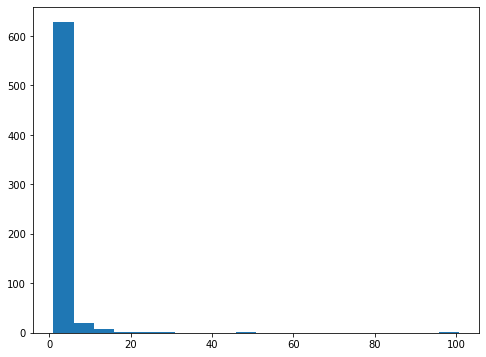

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(weights, bins=20);

In [10]:
y = data.G3
X = data[['constant', 'binary_Dalc']]

In [11]:
wls = sm.WLS(y, X, weights=weights) 
res = wls.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,10.7039,0.251,42.639,0.000,10.211,11.197
binary_Dalc,0.5740,0.346,1.657,0.098,-0.106,1.254


In [12]:
est = res.params.binary_Dalc
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['binary_Dalc'], conf_ints[1]['binary_Dalc']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1       0.57   (-0.1, 1.3)
